In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

In [2]:
from detectron2.structures import BoxMode

# Only for train, val dataset
def get_face_dicts(img_dir, annot_dir, phase) -> list[dict]:
    annot_file = os.path.join(annot_dir, f"{phase}.txt")
    with open (annot_file, 'r') as f:
        lines = f.readlines()

    dataset_dicts = []

    i = 0
    idx = 0
    while i < len(lines):
        record = {}

        image_path = lines[i].strip()
        image_full_path = os.path.join(img_dir, image_path)
        height, width = cv2.imread(image_full_path).shape[:2]

        record["file_name"] = image_full_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []

        num_faces = int(lines[i + 1].strip())
        for j in range(num_faces):
            bbox = list(map(int, lines[i + 2 + j].strip().split())) # # even 1 bbox when num_faces = 0 
            x, y, w, h = bbox[:4] # (x, y) : top-left
            xmin = x
            xmax = x + w
            ymin = y
            ymax = y + h

            poly = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
            poly = [p for x in poly for p in x] # flatten list of list

            obj = {
                 "bbox": [x, y, w, h],
                 "bbox_mode": BoxMode.XYWH_ABS,
                 "segmentation": [poly],
                 "category_id": 0,
            }           
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)
        i += max(2 + num_faces, 3) # 3 when num_faces = 0 
        idx += 1

    return dataset_dicts

In [13]:
# example (train)
p = 'val'
img_dir = f'/workspace/face_mosaic/data/widerface/{p}/images'
annot_dir = '/workspace/face_mosaic/data/widerface/annotations/'
dataset_dicts = get_face_dicts(img_dir, annot_dir, p)

In [60]:
# Remove existing dataset
for p in ["train", "val"]:
    dataset_name = f"face_{p}"
    if dataset_name in DatasetCatalog.list():
        DatasetCatalog.remove(dataset_name)
        MetadataCatalog.remove(dataset_name)

In [3]:
# train
train_dir = '/workspace/face_mosaic/data/widerface/train/images'
annot_dir = '/workspace/face_mosaic/data/widerface/annotations/'
DatasetCatalog.register("face_train", lambda p='train': get_face_dicts(train_dir, annot_dir, p))
MetadataCatalog.get("face_train").set(thing_classes=["face"])

# val
val_dir = '/workspace/face_mosaic/data/widerface/val/images'
annot_dir = '/workspace/face_mosaic/data/widerface/annotations/'
DatasetCatalog.register("face_val", lambda p='val': get_face_dicts(val_dir, annot_dir, p))
MetadataCatalog.get("face_val").set(thing_classes=["face"])

namespace(name='face_val', thing_classes=['face'])

In [ ]:
for p in ["train", "val"]:
    img_dir = f'/workspace/face_mosaic/data/widerface/{p}/images'
    annot_dir = '/workspace/face_mosaic/data/widerface/annotations/'
    
    # DatasetCatalog.register("my_dataset", my_dataset_function)
    DatasetCatalog.register("face_" + p, lambda p=p: get_face_dicts(img_dir, annot_dir, p))
    # MetadataCatalog.get("my_dataset").thing_classes = ["person", "dog"]
    MetadataCatalog.get("face_" + p).set(thing_classes=["face"])

In [4]:
face_metadata = MetadataCatalog.get("face_val")
class_names = face_metadata.get("thing_classes", [])
print(class_names)

['face']


In [5]:
for d in random.sample(dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    visualizer = Visualizer(img[:, :, ::-1], metadata=face_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()

NameError: name 'dataset_dicts' is not defined

In [6]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

In [7]:
# Configs
cfg.DATASETS.TRAIN = ("face_train",)
cfg.DATASETS.TEST = ("face_val",)
cfg.DATALOADER.NUM_WORKERS = 4

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # RoIHead batch size (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (face)

cfg.SOLVER.IMS_PER_BATCH = 2  # images per batch (4)
cfg.SOLVER.BASE_LR = 0.00025  # learning rate
cfg.SOLVER.MAX_ITER = 300     # max iteration (1500)
# cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.STEPS = []         # the checkpoints (number of iterations) at which the learning rate will be reduced by GAMMA
# cfg.SOLVER.GAMMA = 0.05     # learning rate decay

cfg.TEST.EVAL_PERIOD = 500

cfg.OUT_DIR = '/workspace/face_mosaic/result'

In [8]:
import torch

print("Available GPUs:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current device: {device}")

os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"

Available GPUs: 4
GPU 0: NVIDIA RTX A5000
GPU 1: NVIDIA RTX A5000
GPU 2: NVIDIA RTX A5000
GPU 3: NVIDIA RTX A5000
Current device: cuda


In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):
   
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [10]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[08/16 13:17:29 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[08/16 13:18:11 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392067780/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/16 13:18:19 d2.utils.events]:  eta: 0:01:31  iter: 19  total_loss: 2.054  loss_cls: 0.6766  loss_box_reg: 0.01499  loss_mask: 0.6869  loss_rpn_cls: 0.4103  loss_rpn_loc: 0.1462    time: 0.3274  last_time: 0.3099  data_time: 0.0153  last_data_time: 0.0075   lr: 1.6068e-05  max_mem: 3527M


2024-08-16 13:18:19.341028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 13:18:19.361284: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 13:18:19.367332: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 13:18:19.381540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 13:18:20.187847: W tensorflow/comp

[08/16 13:18:27 d2.utils.events]:  eta: 0:01:24  iter: 39  total_loss: 1.756  loss_cls: 0.5304  loss_box_reg: 0.03263  loss_mask: 0.6497  loss_rpn_cls: 0.3373  loss_rpn_loc: 0.09881    time: 0.3152  last_time: 0.2573  data_time: 0.0060  last_data_time: 0.0143   lr: 3.2718e-05  max_mem: 3535M
[08/16 13:18:32 d2.utils.events]:  eta: 0:01:16  iter: 59  total_loss: 1.399  loss_cls: 0.3113  loss_box_reg: 0.02519  loss_mask: 0.5732  loss_rpn_cls: 0.3104  loss_rpn_loc: 0.1183    time: 0.2991  last_time: 0.3254  data_time: 0.0039  last_data_time: 0.0008   lr: 4.9367e-05  max_mem: 3655M
[08/16 13:18:37 d2.utils.events]:  eta: 0:01:10  iter: 79  total_loss: 0.829  loss_cls: 0.1857  loss_box_reg: 0.06245  loss_mask: 0.5052  loss_rpn_cls: 0.1341  loss_rpn_loc: 0.0164    time: 0.2915  last_time: 0.3632  data_time: 0.0051  last_data_time: 0.0038   lr: 6.6017e-05  max_mem: 3655M
[08/16 13:18:43 d2.utils.events]:  eta: 0:01:03  iter: 99  total_loss: 0.8646  loss_cls: 0.163  loss_box_reg: 0.07692  loss

In [18]:
!kill 7119

In [19]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference

In [20]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[08/16 13:40:53 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_face_dicts(val_dir, annot_dir, 'val')

In [ ]:
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=face_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()

In [78]:
# From result/{current time}_{backbone}/model_final.pth
ckpt_path = '/workspace/face_mosaic/result/20240816_1408_mask_rcnn_R_101_FPN_3x'
cfg.MODEL.WEIGHTS = os.path.join(ckpt_path, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)


[08/16 15:15:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /workspace/face_mosaic/result/20240816_1408_mask_rcnn_R_101_FPN_3x/model_final.pth ...


In [79]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_face_dicts(val_dir, annot_dir, 'val')

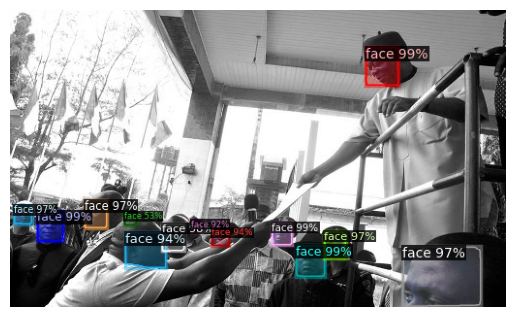

In [100]:
for d in random.sample(dataset_dicts, 1):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=face_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()
    # print(outputs["instances"])
    # print(outputs["instances"].pred_boxes)
    # print(outputs["instances"].pred_classes)
    # print(outputs["instances"].scores)
    # print(outputs["instances"].pred_boxes.tensor)
    # print(outputs["instances"].pred_masks)